# 음향 데이터
출처: https://www.kaggle.com/datasets/mmoreaux/environmental-sound-classification-50

### 목차
1. 데이터 전처리 (wav file -> DataFrame)
2. 표준화 및 라벨링 작업
3. 모델링 작업 반복
4. 예측

In [1]:
# 코랩 위치 옮기기
cd /content/drive/MyDrive/Colab Notebooks/Kaggle/sound/

/content/drive/MyDrive/Colab Notebooks/Kaggle/sound


In [ ]:
# GPU에 메모리 할당
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

## 1. 데이터 전처리(wav file->DataFrame)
- librosa 패키지를 이용해 wav파일에서 특성을 추출한 MFCC (Mel-Frequency Cepstral Coefficient)로 변환
- Numpy 형태로 표현된 MFCC 값들을 딥러닝에 이용

In [2]:
# 모듈 로딩
import librosa
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import set_random_seed, to_categorical
from tensorflow.keras.applications import VGG16
from keras.models import save_model, load_model # 모델 저장 및 로드
import IPython.display as ipd


In [3]:
# 경로 설정 및 데이터 불러오기
PATH = './audio/audio/16000'
esc = pd.read_csv("esc50.csv")
esc.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [11]:
# 불필요한 컬럼 삭제
esc.drop(inplace=True, columns=['fold', 'category', 'esc10', 'src_file', 'take'])

In [12]:
# 데이터 확인
esc.head()

,filename,target
0,1-100032-A-0.wav,0
1,1-100038-A-14.wav,14
2,1-100210-A-36.wav,36
3,1-100210-B-36.wav,36
4,1-101296-A-19.wav,19


In [ ]:
ipd.Audio(PATH + '/1-100038-A-14.wav' )

In [ ]:
ipd.Audio(PATH + '/1-100210-B-36.wav' )

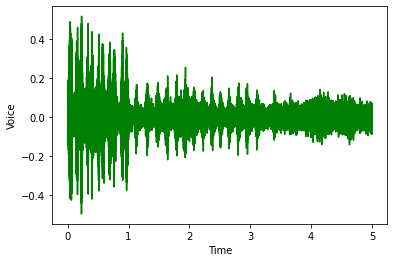

In [4]:
# 목소리 그래프 그리기
def voice(FILENAME):
    signal, sr = librosa.load(FILENAME, sr=16000)
    time = np.linspace(0, len(signal)/16000 , len(signal))
    fig, ax = plt.subplots()
    ax.plot(time, signal, color='g')
    ax.set_xlabel("Time")
    ax.set_ylabel("Voice")
    plt.show()

voice(PATH + "//1-100038-A-14.wav")

### librosa.feature.mfcc의 파라미터 설명
|파라미터|디폴트|설명|
|------|---|---|
|sr|22050|wav파일은 sr=16000으로 고정|
|n_mfcc|20|특징벡터의 개수 결정|
|n_fft|2048|음성의 길이를 얼만큼 자를지 결정하는 파라미터, n_fft = 0.025*sr|
|hop_length|512|길이만큼 데이터를 읽음, hop_length = 0.01*sr|
|S|None|log-power Mel spectrogram|
|dct_type|2|{1,2,3} 중 선택|

In [85]:
# wav파일의 PATH가 주어졌을 때, librosa로 데이터 로딩
import os

x= []; y= []
PATH = './audio/audio/16000'
for data in tqdm(esc.iterrows(), desc='Progress'):
    signal, sr = librosa.load(PATH + f"/{data[1][0]}" ,sr=16000)
    # sr은 16000으로 고정, n_mfcc는 변동
    sound_mfcc = librosa.feature.mfcc(signal, sr, n_mfcc=48, n_fft=400,hop_length=160)
    x.append(sound_mfcc) 
    y.append(data[1][1])

Progress: 2000it [00:33, 58.98it/s]


In [86]:
# 전처리 과정
x = np.array(x)
y = np.array(y)

In [87]:
print(x.shape, y.shape)

(2000, 48, 501) (2000,)


In [88]:
# numpy값 저장
np.save("x_save_48", x)
np.save("y_save_48", y)

In [24]:
# numpy값 확인
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [19]:
# 분류 항목 값 살펴보기
dic = {}
dg = pd.read_csv('esc50.csv')
for i in range(50):
  dic[i] = dg.loc[dg['target'] == i, 'category'].head(1).tolist()[0]

In [20]:
dic

{0: 'dog',
 1: 'rooster',
 2: 'pig',
 3: 'cow',
 4: 'frog',
 5: 'cat',
 6: 'hen',
 7: 'insects',
 8: 'sheep',
 9: 'crow',
 10: 'rain',
 11: 'sea_waves',
 12: 'crackling_fire',
 13: 'crickets',
 14: 'chirping_birds',
 15: 'water_drops',
 16: 'wind',
 17: 'pouring_water',
 18: 'toilet_flush',
 19: 'thunderstorm',
 20: 'crying_baby',
 21: 'sneezing',
 22: 'clapping',
 23: 'breathing',
 24: 'coughing',
 25: 'footsteps',
 26: 'laughing',
 27: 'brushing_teeth',
 28: 'snoring',
 29: 'drinking_sipping',
 30: 'door_wood_knock',
 31: 'mouse_click',
 32: 'keyboard_typing',
 33: 'door_wood_creaks',
 34: 'can_opening',
 35: 'washing_machine',
 36: 'vacuum_cleaner',
 37: 'clock_alarm',
 38: 'clock_tick',
 39: 'glass_breaking',
 40: 'helicopter',
 41: 'chainsaw',
 42: 'siren',
 43: 'car_horn',
 44: 'engine',
 45: 'train',
 46: 'church_bells',
 47: 'airplane',
 48: 'fireworks',
 49: 'hand_saw'}

## 2. 표준화 및 라벨링 작업

In [89]:
# numpy값 불러오기
x = np.load('x_save_48.npy')
y = np.load('y_save_48.npy')

In [90]:
# train, val, test 값으로 쪼개기
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state=42, test_size=0.2, stratify=y)
train_y = to_categorical(train_y, num_classes=50)
test_y = to_categorical(test_y, num_classes=50)
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, random_state=42, test_size=0.2, stratify=train_y)

## 3. 모델링 작업 반복
- 3-1. CNN
- 3-2. SVC
- 3-3. CNN 성능 개선

### 3-1. CNN

In [95]:
# CNN 모델링1
md = Sequential()
md.add(Conv2D(32, (3,3), padding='valid', activation='relu', input_shape=(48,501,1)))
md.add(MaxPool2D(2, padding='same'))
md.add(Dropout(0.3))
md.add(Conv2D(128, (3,3), padding='valid', activation='relu'))
md.add(MaxPool2D(2, padding='same'))
md.add(Dropout(0.3))
md.add(Conv2D(128, (3,3), padding='valid', activation='relu'))
md.add(MaxPool2D(2, padding='same'))
md.add(Dropout(0.3))
md.add(GlobalAveragePooling2D())
md.add(Dense(512, activation='relu'))
md.add(Dropout(0.3))
md.add(Dense(50, activation='softmax'))
md.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 499, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 250, 32)      0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 23, 250, 32)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 248, 128)      36992     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 11, 124, 128)     0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 11, 124, 128)     

In [96]:
# CNN 모델링2
md.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='acc')
batch_size = 8
mcp = ModelCheckpoint("checkpoint", monitor='val_accuracy', save_best_only=True)
es = EarlyStopping("val_acc", min_delta=0, patience=10)
history = md.fit(train_x,train_y ,
            validation_data=(val_x, val_y),
            epochs=50,batch_size=batch_size, callbacks=[mcp, es])

Epoch 1/50
160/160 [==============================] - ETA: 0s - loss: 3.8820 - acc: 0.0414

160/160 [==============================] - 88s 544ms/step - loss: 3.8820 - acc: 0.0414 - val_loss: 3.4585 - val_acc: 0.1000
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 3.2043 - acc: 0.1352

160/160 [==============================] - 85s 532ms/step - loss: 3.2043 - acc: 0.1352 - val_loss: 2.9621 - val_acc: 0.2000
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 2.8279 - acc: 0.2023

160/160 [==============================] - 85s 532ms/step - loss: 2.8279 - acc: 0.2023 - val_loss: 2.6850 - val_acc: 0.2656
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 2.5656 - acc: 0.2641

160/160 [==============================] - 85s 529ms/step - loss: 2.5656 - acc: 0.2641 - val_loss: 2.7238 - val_acc: 0.2531
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 2.3871 - acc: 0.2969

160/160 [==============================] - 85s 534ms/step - loss: 2.3871 - acc: 0.2969 - val_loss: 2.6448 - val_acc: 0.2937
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 2.2448 - acc: 0.3695

160/160 [==============================] - 85s 530ms/step - loss: 2.2448 - acc: 0.3695 - val_loss: 2.2570 - val_acc: 0.3719
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 2.0851 - acc: 0.3883

160/160 [==============================] - 85s 531ms/step - loss: 2.0851 - acc: 0.3883 - val_loss: 2.7464 - val_acc: 0.2375
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 1.9676 - acc: 0.4297

160/160 [==============================] - 90s 564ms/step - loss: 1.9676 - acc: 0.4297 - val_loss: 2.2545 - val_acc: 0.3562
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 1.8526 - acc: 0.4648

160/160 [==============================] - 85s 529ms/step - loss: 1.8526 - acc: 0.4648 - val_loss: 2.0491 - val_acc: 0.4500
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 1.7904 - acc: 0.4633

160/160 [==============================] - 84s 528ms/step - loss: 1.7904 - acc: 0.4633 - val_loss: 2.0538 - val_acc: 0.4563
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 1.6653 - acc: 0.5180

160/160 [==============================] - 84s 527ms/step - loss: 1.6653 - acc: 0.5180 - val_loss: 2.2121 - val_acc: 0.4094
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 1.5901 - acc: 0.5344

160/160 [==============================] - 84s 528ms/step - loss: 1.5901 - acc: 0.5344 - val_loss: 2.3320 - val_acc: 0.4375
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 1.5029 - acc: 0.5688

160/160 [==============================] - 85s 529ms/step - loss: 1.5029 - acc: 0.5688 - val_loss: 2.0340 - val_acc: 0.4594
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 1.4260 - acc: 0.5914

160/160 [==============================] - 85s 530ms/step - loss: 1.4260 - acc: 0.5914 - val_loss: 2.1829 - val_acc: 0.4375
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 1.3567 - acc: 0.6023

160/160 [==============================] - 85s 529ms/step - loss: 1.3567 - acc: 0.6023 - val_loss: 2.1521 - val_acc: 0.4469
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 1.2871 - acc: 0.6250

160/160 [==============================] - 85s 530ms/step - loss: 1.2871 - acc: 0.6250 - val_loss: 2.4959 - val_acc: 0.4844
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 1.2244 - acc: 0.6477

160/160 [==============================] - 85s 532ms/step - loss: 1.2244 - acc: 0.6477 - val_loss: 2.1345 - val_acc: 0.5188
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 1.1580 - acc: 0.6531

160/160 [==============================] - 85s 533ms/step - loss: 1.1580 - acc: 0.6531 - val_loss: 2.2442 - val_acc: 0.5000
Epoch 19/50
160/160 [==============================] - ETA: 0s - loss: 1.0587 - acc: 0.6820

160/160 [==============================] - 85s 531ms/step - loss: 1.0587 - acc: 0.6820 - val_loss: 2.6493 - val_acc: 0.5000
Epoch 20/50
160/160 [==============================] - ETA: 0s - loss: 1.1044 - acc: 0.6938

160/160 [==============================] - 85s 531ms/step - loss: 1.1044 - acc: 0.6938 - val_loss: 1.7925 - val_acc: 0.5375
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.9907 - acc: 0.7227

160/160 [==============================] - 85s 531ms/step - loss: 0.9907 - acc: 0.7227 - val_loss: 2.1097 - val_acc: 0.5531
Epoch 22/50
160/160 [==============================] - ETA: 0s - loss: 1.0042 - acc: 0.7156

160/160 [==============================] - 85s 533ms/step - loss: 1.0042 - acc: 0.7156 - val_loss: 1.9986 - val_acc: 0.5656
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.9295 - acc: 0.7242

160/160 [==============================] - 85s 532ms/step - loss: 0.9295 - acc: 0.7242 - val_loss: 2.2079 - val_acc: 0.5688
Epoch 24/50
160/160 [==============================] - ETA: 0s - loss: 0.9069 - acc: 0.7281

160/160 [==============================] - 85s 532ms/step - loss: 0.9069 - acc: 0.7281 - val_loss: 2.1279 - val_acc: 0.5781
Epoch 25/50
160/160 [==============================] - ETA: 0s - loss: 0.8343 - acc: 0.7609

160/160 [==============================] - 85s 532ms/step - loss: 0.8343 - acc: 0.7609 - val_loss: 2.2424 - val_acc: 0.5656
Epoch 26/50
160/160 [==============================] - ETA: 0s - loss: 0.8375 - acc: 0.7625

160/160 [==============================] - 89s 554ms/step - loss: 0.8375 - acc: 0.7625 - val_loss: 2.7945 - val_acc: 0.5625
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 0.7723 - acc: 0.7609

160/160 [==============================] - 85s 531ms/step - loss: 0.7723 - acc: 0.7609 - val_loss: 2.8658 - val_acc: 0.5094
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.8156 - acc: 0.7836

160/160 [==============================] - 85s 532ms/step - loss: 0.8156 - acc: 0.7836 - val_loss: 2.2533 - val_acc: 0.6125
Epoch 29/50
160/160 [==============================] - ETA: 0s - loss: 0.7986 - acc: 0.7781

160/160 [==============================] - 85s 533ms/step - loss: 0.7986 - acc: 0.7781 - val_loss: 2.6235 - val_acc: 0.5531
Epoch 30/50
160/160 [==============================] - ETA: 0s - loss: 0.7204 - acc: 0.8062

160/160 [==============================] - 86s 535ms/step - loss: 0.7204 - acc: 0.8062 - val_loss: 3.0109 - val_acc: 0.5219
Epoch 31/50
160/160 [==============================] - ETA: 0s - loss: 0.6595 - acc: 0.8164

160/160 [==============================] - 85s 532ms/step - loss: 0.6595 - acc: 0.8164 - val_loss: 2.9530 - val_acc: 0.5813
Epoch 32/50
160/160 [==============================] - ETA: 0s - loss: 0.7219 - acc: 0.8016

160/160 [==============================] - 85s 533ms/step - loss: 0.7219 - acc: 0.8016 - val_loss: 3.0210 - val_acc: 0.6000
Epoch 33/50
160/160 [==============================] - ETA: 0s - loss: 0.6763 - acc: 0.8164

160/160 [==============================] - 85s 532ms/step - loss: 0.6763 - acc: 0.8164 - val_loss: 2.7421 - val_acc: 0.5562
Epoch 34/50
160/160 [==============================] - ETA: 0s - loss: 0.7619 - acc: 0.8023

160/160 [==============================] - 85s 532ms/step - loss: 0.7619 - acc: 0.8023 - val_loss: 2.5341 - val_acc: 0.5938
Epoch 35/50
160/160 [==============================] - ETA: 0s - loss: 0.6167 - acc: 0.8203

160/160 [==============================] - 85s 532ms/step - loss: 0.6167 - acc: 0.8203 - val_loss: 3.7704 - val_acc: 0.5125
Epoch 36/50
160/160 [==============================] - ETA: 0s - loss: 0.6772 - acc: 0.8211

160/160 [==============================] - 85s 532ms/step - loss: 0.6772 - acc: 0.8211 - val_loss: 3.4744 - val_acc: 0.5906
Epoch 37/50
160/160 [==============================] - ETA: 0s - loss: 0.7282 - acc: 0.8258

160/160 [==============================] - 85s 532ms/step - loss: 0.7282 - acc: 0.8258 - val_loss: 3.4010 - val_acc: 0.5781
Epoch 38/50
160/160 [==============================] - ETA: 0s - loss: 0.6315 - acc: 0.8289

160/160 [==============================] - 85s 533ms/step - loss: 0.6315 - acc: 0.8289 - val_loss: 2.9553 - val_acc: 0.5750


In [97]:
# 모델 저장
md.save("cnn_result_48.h5")

In [98]:
# 모델 로딩 & 평가
md = load_model("cnn_result_48.h5")
md.evaluate(test_x, test_y)

13/13 [==============================] - 7s 492ms/step - loss: 3.0180 - acc: 0.5775


[3.0180389881134033, 0.5774999856948853]

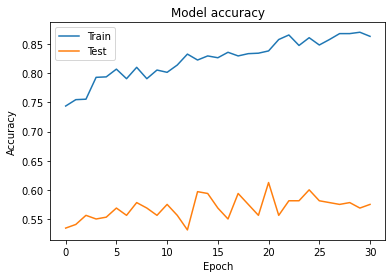

In [38]:
# n_mfcc=30일때 train, test 그래프
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

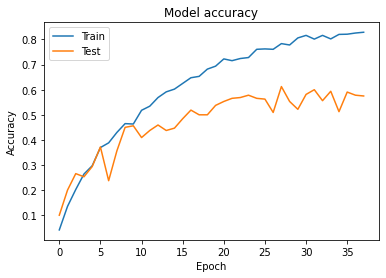

In [99]:
# n_mfcc=48일때 train, test 그래프
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [56]:
# 예측값 확인
x= []; y= [5,0,8,45,36]
PATH = './predict/'
for i in os.listdir(PATH):
    signal, sr = librosa.load(PATH + i ,sr=16000)
    # sr은 16000으로 고정, n_mfcc는 변동
    sound_mfcc = librosa.feature.mfcc(signal, sr, n_mfcc=30, n_fft=400,hop_length=160)
    x.append(sound_mfcc) 
x[0] = x[0][:,:501]
x[1] = x[1][:,:501]
x[2] = x[2][:,:501]
x[3] = x[3][:,:501]
x[4] = x[4][:,:501]
x = np.array(x)
y = np.array(y)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = to_categorical(y, num_classes=50)
print(x.shape, y.shape)

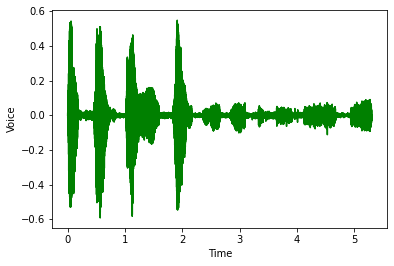

In [78]:
# 개 목소리 들어보기
voice("./predict/dog0.wav")

In [84]:
print("예측값: ",[dic[i] for i in md.predict(x).argmax(axis=1)])
print("실제값: ",[dic[i] for i in [0,36,8,5,45]])

예측값:  ['hen', 'washing_machine', 'cat', 'cat', 'church_bells']
실제값:  ['cat', 'dog', 'sheep', 'train', 'vacuum_cleaner']


- CNN 최종결과(20) : 0.6
- CNN 최종결과(30) : 0.59
- CNN 최종결과(48) : 0.578

### 3-2. SVC

In [ ]:
train_x_scaled = train_x.reshape(-1, 20*501)
test_x_scaled = test_x.reshape(-1, 20*501)
val_x_scaled = val_x.reshape(-1,20*501)

In [ ]:
# 표준화
st = StandardScaler()
st.fit(train_x_scaled)
train_x_scaled = st.transform(train_x_scaled)
test_x_scaled = st.transform(test_x_scaled)
val_x_scaled = st.transform(val_x_scaled)

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(train_x_scaled, train_y)

SVC()

In [ ]:
print(svc.score(train_x_scaled, train_y))
print(svc.score(val_x_scaled, val_y))
print(svc.score(test_x_scaled, test_y))

0.9328125
0.390625
0.3925


### 3-3. CNN 성능 개선

In [145]:
# CNN 성능 개선
md = Sequential()
md.add(Conv2D(32, (3,3), padding='valid', activation='relu', input_shape=(48,501,1)))
md.add(MaxPool2D(2, padding='same'))
md.add(Dropout(0.3))
md.add(Conv2D(128, (3,3), padding='valid', activation='relu'))
md.add(MaxPool2D(2, padding='same'))
md.add(Dropout(0.3))
md.add(Conv2D(128, (3,3), padding='valid', activation='relu'))
md.add(MaxPool2D(2, padding='same'))
md.add(Dropout(0.3))
md.add(GlobalAveragePooling2D())
md.add(Dense(256, activation='relu'))
md.add(Dropout(0.3))
md.add(Dense(50, activation='softmax'))
md.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='acc')
batch_size = 8
md.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_158 (Conv2D)         (None, 46, 499, 32)       320       
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 23, 250, 32)      0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 23, 250, 32)       0         
                                                                 
 conv2d_159 (Conv2D)         (None, 21, 248, 128)      36992     
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 11, 124, 128)     0         
 g2D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 11, 124, 128)    

In [146]:
# CNN 성능 개선2
batch_size = 8
mcp = ModelCheckpoint("checkpoint", monitor='val_accuracy', save_best_only=True)
es = EarlyStopping("val_loss", min_delta=0, patience=10)
history = md.fit(train_x,train_y,
            validation_data=(val_x, val_y),
            epochs=50,batch_size=batch_size, callbacks=[mcp])

Epoch 1/50
160/160 [==============================] - ETA: 0s - loss: 3.9366 - acc: 0.0469

160/160 [==============================] - 87s 536ms/step - loss: 3.9366 - acc: 0.0469 - val_loss: 3.6072 - val_acc: 0.1187
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 3.3700 - acc: 0.1148

160/160 [==============================] - 84s 525ms/step - loss: 3.3700 - acc: 0.1148 - val_loss: 3.2172 - val_acc: 0.1219
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 3.0197 - acc: 0.1648

160/160 [==============================] - 84s 525ms/step - loss: 3.0197 - acc: 0.1648 - val_loss: 2.8160 - val_acc: 0.2281
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 2.7291 - acc: 0.2273

160/160 [==============================] - 84s 525ms/step - loss: 2.7291 - acc: 0.2273 - val_loss: 2.5599 - val_acc: 0.3406
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 2.5601 - acc: 0.2648

160/160 [==============================] - 84s 525ms/step - loss: 2.5601 - acc: 0.2648 - val_loss: 2.5157 - val_acc: 0.3250
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 2.3827 - acc: 0.3031

160/160 [==============================] - 84s 525ms/step - loss: 2.3827 - acc: 0.3031 - val_loss: 2.3954 - val_acc: 0.3500
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 2.2106 - acc: 0.3805

160/160 [==============================] - 84s 525ms/step - loss: 2.2106 - acc: 0.3805 - val_loss: 2.2742 - val_acc: 0.3906
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 2.0854 - acc: 0.3852

160/160 [==============================] - 84s 523ms/step - loss: 2.0854 - acc: 0.3852 - val_loss: 2.2171 - val_acc: 0.3938
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 2.0076 - acc: 0.4070

160/160 [==============================] - 84s 523ms/step - loss: 2.0076 - acc: 0.4070 - val_loss: 2.0999 - val_acc: 0.4406
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 1.9045 - acc: 0.4594

160/160 [==============================] - 84s 524ms/step - loss: 1.9045 - acc: 0.4594 - val_loss: 2.1563 - val_acc: 0.3906
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 1.8350 - acc: 0.4578

160/160 [==============================] - 84s 525ms/step - loss: 1.8350 - acc: 0.4578 - val_loss: 1.9862 - val_acc: 0.4875
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 1.7594 - acc: 0.4852

160/160 [==============================] - 84s 525ms/step - loss: 1.7594 - acc: 0.4852 - val_loss: 2.0386 - val_acc: 0.4281
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 1.6630 - acc: 0.5063

160/160 [==============================] - 84s 523ms/step - loss: 1.6630 - acc: 0.5063 - val_loss: 1.9642 - val_acc: 0.4625
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 1.5941 - acc: 0.5445

160/160 [==============================] - 84s 523ms/step - loss: 1.5941 - acc: 0.5445 - val_loss: 2.0238 - val_acc: 0.4719
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 1.5437 - acc: 0.5562

160/160 [==============================] - 84s 522ms/step - loss: 1.5437 - acc: 0.5562 - val_loss: 2.3644 - val_acc: 0.4125
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 1.4233 - acc: 0.5922

160/160 [==============================] - 84s 522ms/step - loss: 1.4233 - acc: 0.5922 - val_loss: 2.0611 - val_acc: 0.5063
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 1.3663 - acc: 0.5930

160/160 [==============================] - 84s 523ms/step - loss: 1.3663 - acc: 0.5930 - val_loss: 2.0768 - val_acc: 0.4875
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 1.3933 - acc: 0.6047

160/160 [==============================] - 84s 523ms/step - loss: 1.3933 - acc: 0.6047 - val_loss: 1.9938 - val_acc: 0.5594
Epoch 19/50
160/160 [==============================] - ETA: 0s - loss: 1.2764 - acc: 0.6180

160/160 [==============================] - 84s 524ms/step - loss: 1.2764 - acc: 0.6180 - val_loss: 2.2220 - val_acc: 0.5188
Epoch 20/50
160/160 [==============================] - ETA: 0s - loss: 1.2212 - acc: 0.6375

160/160 [==============================] - 84s 524ms/step - loss: 1.2212 - acc: 0.6375 - val_loss: 2.1287 - val_acc: 0.5219
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 1.2170 - acc: 0.6531

160/160 [==============================] - 94s 589ms/step - loss: 1.2170 - acc: 0.6531 - val_loss: 1.9394 - val_acc: 0.5344
Epoch 22/50
160/160 [==============================] - ETA: 0s - loss: 1.1687 - acc: 0.6641

160/160 [==============================] - 87s 543ms/step - loss: 1.1687 - acc: 0.6641 - val_loss: 2.2310 - val_acc: 0.5469
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 1.1273 - acc: 0.6766

160/160 [==============================] - 103s 646ms/step - loss: 1.1273 - acc: 0.6766 - val_loss: 2.2879 - val_acc: 0.5156
Epoch 24/50
160/160 [==============================] - ETA: 0s - loss: 1.0468 - acc: 0.7023

160/160 [==============================] - 105s 654ms/step - loss: 1.0468 - acc: 0.7023 - val_loss: 2.1337 - val_acc: 0.5500
Epoch 25/50
160/160 [==============================] - ETA: 0s - loss: 1.0222 - acc: 0.6969

160/160 [==============================] - 88s 553ms/step - loss: 1.0222 - acc: 0.6969 - val_loss: 2.3664 - val_acc: 0.5562
Epoch 26/50
160/160 [==============================] - ETA: 0s - loss: 0.9920 - acc: 0.7172

160/160 [==============================] - 84s 523ms/step - loss: 0.9920 - acc: 0.7172 - val_loss: 2.2918 - val_acc: 0.5969
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 1.0218 - acc: 0.7063

160/160 [==============================] - 83s 522ms/step - loss: 1.0218 - acc: 0.7063 - val_loss: 2.1340 - val_acc: 0.5656
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.9216 - acc: 0.7312

160/160 [==============================] - 84s 523ms/step - loss: 0.9216 - acc: 0.7312 - val_loss: 2.5026 - val_acc: 0.5250
Epoch 29/50
160/160 [==============================] - ETA: 0s - loss: 0.8740 - acc: 0.7414

160/160 [==============================] - 83s 522ms/step - loss: 0.8740 - acc: 0.7414 - val_loss: 2.8526 - val_acc: 0.5406
Epoch 30/50
160/160 [==============================] - ETA: 0s - loss: 0.8685 - acc: 0.7445

160/160 [==============================] - 84s 523ms/step - loss: 0.8685 - acc: 0.7445 - val_loss: 2.6431 - val_acc: 0.5844
Epoch 31/50
160/160 [==============================] - ETA: 0s - loss: 0.9144 - acc: 0.7383

160/160 [==============================] - 84s 522ms/step - loss: 0.9144 - acc: 0.7383 - val_loss: 2.2332 - val_acc: 0.6156
Epoch 32/50
160/160 [==============================] - ETA: 0s - loss: 0.8448 - acc: 0.7594

160/160 [==============================] - 91s 571ms/step - loss: 0.8448 - acc: 0.7594 - val_loss: 2.4238 - val_acc: 0.5594
Epoch 33/50
160/160 [==============================] - ETA: 0s - loss: 0.8629 - acc: 0.7523

160/160 [==============================] - 84s 524ms/step - loss: 0.8629 - acc: 0.7523 - val_loss: 2.3374 - val_acc: 0.5813
Epoch 34/50
160/160 [==============================] - ETA: 0s - loss: 0.8000 - acc: 0.7781

160/160 [==============================] - 84s 525ms/step - loss: 0.8000 - acc: 0.7781 - val_loss: 2.2934 - val_acc: 0.6000
Epoch 35/50
160/160 [==============================] - ETA: 0s - loss: 0.7496 - acc: 0.7883

160/160 [==============================] - 84s 526ms/step - loss: 0.7496 - acc: 0.7883 - val_loss: 2.8567 - val_acc: 0.5875
Epoch 36/50
160/160 [==============================] - ETA: 0s - loss: 0.8586 - acc: 0.7719

160/160 [==============================] - 84s 527ms/step - loss: 0.8586 - acc: 0.7719 - val_loss: 2.4006 - val_acc: 0.6031
Epoch 37/50
160/160 [==============================] - ETA: 0s - loss: 0.7401 - acc: 0.7867

160/160 [==============================] - 84s 526ms/step - loss: 0.7401 - acc: 0.7867 - val_loss: 2.8236 - val_acc: 0.5781
Epoch 38/50
160/160 [==============================] - ETA: 0s - loss: 0.7261 - acc: 0.7906

160/160 [==============================] - 84s 523ms/step - loss: 0.7261 - acc: 0.7906 - val_loss: 2.7568 - val_acc: 0.5938
Epoch 39/50
160/160 [==============================] - ETA: 0s - loss: 0.7386 - acc: 0.7883

160/160 [==============================] - 84s 523ms/step - loss: 0.7386 - acc: 0.7883 - val_loss: 2.8934 - val_acc: 0.5781
Epoch 40/50
160/160 [==============================] - ETA: 0s - loss: 0.7661 - acc: 0.7977

160/160 [==============================] - 84s 524ms/step - loss: 0.7661 - acc: 0.7977 - val_loss: 2.9993 - val_acc: 0.5750
Epoch 41/50
160/160 [==============================] - ETA: 0s - loss: 0.7932 - acc: 0.7977

160/160 [==============================] - 84s 523ms/step - loss: 0.7932 - acc: 0.7977 - val_loss: 2.6463 - val_acc: 0.6125
Epoch 42/50
160/160 [==============================] - ETA: 0s - loss: 0.7091 - acc: 0.8055

160/160 [==============================] - 86s 538ms/step - loss: 0.7091 - acc: 0.8055 - val_loss: 2.4927 - val_acc: 0.6438
Epoch 43/50
160/160 [==============================] - ETA: 0s - loss: 0.6461 - acc: 0.8070

160/160 [==============================] - 84s 524ms/step - loss: 0.6461 - acc: 0.8070 - val_loss: 2.7181 - val_acc: 0.6281
Epoch 44/50
160/160 [==============================] - ETA: 0s - loss: 0.6538 - acc: 0.8141

160/160 [==============================] - 84s 523ms/step - loss: 0.6538 - acc: 0.8141 - val_loss: 3.0493 - val_acc: 0.6156
Epoch 45/50
160/160 [==============================] - ETA: 0s - loss: 0.7072 - acc: 0.8195

160/160 [==============================] - 84s 524ms/step - loss: 0.7072 - acc: 0.8195 - val_loss: 2.8530 - val_acc: 0.6062
Epoch 46/50
160/160 [==============================] - ETA: 0s - loss: 0.7479 - acc: 0.8086

160/160 [==============================] - 84s 524ms/step - loss: 0.7479 - acc: 0.8086 - val_loss: 2.8528 - val_acc: 0.6031
Epoch 47/50
160/160 [==============================] - ETA: 0s - loss: 0.6721 - acc: 0.8117

160/160 [==============================] - 84s 524ms/step - loss: 0.6721 - acc: 0.8117 - val_loss: 2.5203 - val_acc: 0.6250
Epoch 48/50
160/160 [==============================] - ETA: 0s - loss: 0.6916 - acc: 0.8313

160/160 [==============================] - 84s 523ms/step - loss: 0.6916 - acc: 0.8313 - val_loss: 3.2247 - val_acc: 0.6062
Epoch 49/50
160/160 [==============================] - ETA: 0s - loss: 0.6643 - acc: 0.8133

160/160 [==============================] - 84s 525ms/step - loss: 0.6643 - acc: 0.8133 - val_loss: 3.1480 - val_acc: 0.5969
Epoch 50/50
160/160 [==============================] - ETA: 0s - loss: 0.8018 - acc: 0.8023

160/160 [==============================] - 84s 525ms/step - loss: 0.8018 - acc: 0.8023 - val_loss: 2.5388 - val_acc: 0.6375


In [147]:
# 값 평가
md.evaluate(test_x, test_y)

13/13 [==============================] - 6s 475ms/step - loss: 2.5332 - acc: 0.6650


[2.5331759452819824, 0.6650000214576721]

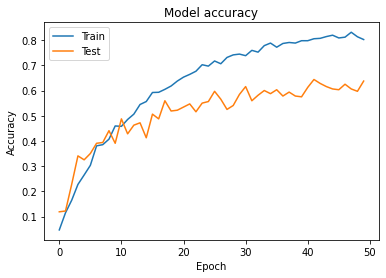

In [148]:
# train, test 그래프
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 4. 예측

In [155]:
# 예측할 값 확인
for i in os.listdir(PATH):
  print(i)    

dog0.wav
vaccum36.wav
sheep8.wav
cat5.wav
train45.wav


In [156]:
# 예측 실행
x= []; y= []
PATH = './predict/'
for i in os.listdir(PATH):
    signal, sr = librosa.load(PATH + i ,sr=16000)
    # sr은 16000으로 고정, n_mfcc는 변동
    sound_mfcc = librosa.feature.mfcc(signal, sr, n_mfcc=48, n_fft=400,hop_length=160)
    x.append(sound_mfcc) 
x[0] = x[0][:,:501]
x[1] = x[1][:,:501]
x[2] = x[2][:,:501]
x[3] = x[3][:,:501]
x[4] = x[4][:,:501]
x = np.array(x)
y = np.array(y)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = to_categorical(y, num_classes=50)
print(x.shape, y.shape)

(5, 48, 501, 1) (0, 50)


In [158]:
print("예측값: ",[dic[i] for i in md.predict(x).argmax(axis=1)])
print("실제값: ",[dic[i] for i in [0,36,8,5,45]])

예측값:  ['hen', 'vacuum_cleaner', 'sheep', 'cat', 'sheep']
실제값:  ['dog', 'vacuum_cleaner', 'sheep', 'cat', 'train']


### 실제 값에서도 60%의 정답률을 보였다.

In [159]:
md.save("cnn_result_best66.h5")

## 결론
1. CNN에서 제일 작동 잘하는 방법은 하이퍼파라미터 n_mfcc = 20 설정할 때이다.
2. SVC, RandomForest 등을 시도해 보았지만, accuracy 0.3근처로 나왔다.
3. 어려웠던 점
  - 어떤 부분을 빼고 더해야(구체적으로 하이퍼파라미터를 바꾼다던지, CNN의 층을 다르게 준다던지) 모델이 좋아지는지 판단하기가 어려웠다.
